<a href="https://colab.research.google.com/github/mov-z/Vision-AI-Tutorials/blob/main/huggingface/SwinT_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Huggingface SwinT Training & Evaluation**

**Huggingface** 라이브러리를 이용하여 **Swin Transformer (SwinT)** 이미지 분류 모델을 커스텀 데이터셋으로 학습하고 평가하는 예제 코드입니다.

이 예제에서는 Huggingface의 **datasets**와 **transformers** 라이브러리를 활용하여 데이터 전처리부터 모델 학습, 성능 평가까지의 전 과정을 다룹니다.



## **1. 환경 세팅**
- 필요 패키지 설치
- 라이브러리 및 모듈 임포트
- 필요 함수 선언

In [1]:
!pip install -q transformers
!pip install -q datasets
!pip install -q evaluate

In [22]:
from transformers import SwinConfig, AutoImageProcessor, SwinForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset
from evaluate import load as load_metric

import torch
import torchvision
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
import numpy as np
import requests
from io import BytesIO
from PIL import Image

In [15]:
def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## **2. 데이터셋 세팅**
- 데이터셋 로드 및 라벨 컬럼명 변경
- 라벨 인덱스 생성 (`feature_extractor`에 필요)


In [4]:
# 데이터셋 로드
dataset = load_dataset("cats_vs_dogs")

In [5]:
# dataset의 features의 'image', 'labels' 를 통일시켜주는 게 편리
# 데이터셋마다 'img', 'image', 'images' 등 다양하게 표기되어 있음
print('기존 :', dataset)
dataset['train'] = dataset['train'].rename_column("labels", "label")
print('변경 후 :',dataset)

# 레이블 인덱스 별 레이블 지정
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print('인덱스 별 레이블 : ',id2label)

기존 : DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})
변경 후 : DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 23410
    })
})
인덱스 별 레이블 :  {0: 'cat', 1: 'dog'}


## **3. SwinT 모델 설정**
- Swin 모델의 설정을 구성하고, 사전 학습된 모델을 로드
- 이미지 전처리를 위해 `AutoImageProcessor'를 불러오고 레이블 매핑 설정


In [8]:
configuration = SwinConfig()
configuration.num_labels = 10

feature_extractor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224",
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes = True,
                                                       )
model = SwinForImageClassification(configuration)

## **4. 데이터 전처리**
- 데이터 전처리 함수 선언
- 데이터 전처리 및 분할


In [9]:
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

In [10]:
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

label : dog


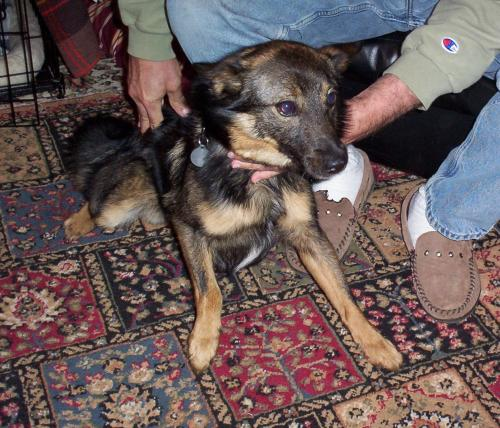

In [11]:
# 데이터셋 잘 적용되었는지 확인
example = train_ds[10]
print('label :',id2label[example['label']])
example['image']

## **5. Hugging Face `Trainer` 설정**
- 배치 전처리와 관련된 데이터 콜레이터 함수와 학습 하이퍼파라미터를 설정
- 여기에는 학습 배치 사이즈, 학습 속도, 로깅 주기, 모델 평가 전략 등이 포함됨


In [12]:
batch_size = 32

training_args = TrainingArguments(output_dir="test_trainer",
                                  remove_unused_columns=False,
                                  evaluation_strategy = "epoch",
                                  save_strategy = "epoch",
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=batch_size,
                                  gradient_accumulation_steps=4,
                                  per_device_eval_batch_size=batch_size,
                                  num_train_epochs=2,
                                  warmup_ratio=0.1,
                                  logging_steps=10,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy",
                                  )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## **6. 모델 학습**
- `Trainer` 클래스를 사용하여 모델을 학습
- 학습 및 평가 결과를 로깅 및 저장


In [17]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.640900,0.626396,0.635626
1,0.599200,0.609830,0.654848


Epoch,Training Loss,Validation Loss


***** train metrics *****
  epoch                    =       1.9909
  total_flos               = 1010492033GF
  train_loss               =       0.6316
  train_runtime            =   0:11:46.10
  train_samples_per_second =       59.677
  train_steps_per_second   =        0.465


## **7. 모델 평가 및 추론**
- 학습된 모델 평가
- 학습된 모델 추론 및 시각화 (저장된 checkpoint 확인 필요)



In [18]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =     1.9909
  eval_accuracy           =     0.6548
  eval_loss               =     0.6098
  eval_runtime            = 0:00:19.09
  eval_samples_per_second =    122.603
  eval_steps_per_second   =      3.876


In [19]:
feature_extractor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
trained_model = SwinForImageClassification(configuration).from_pretrained('/content/test_trainer/checkpoint-328/')

predicted label : dog


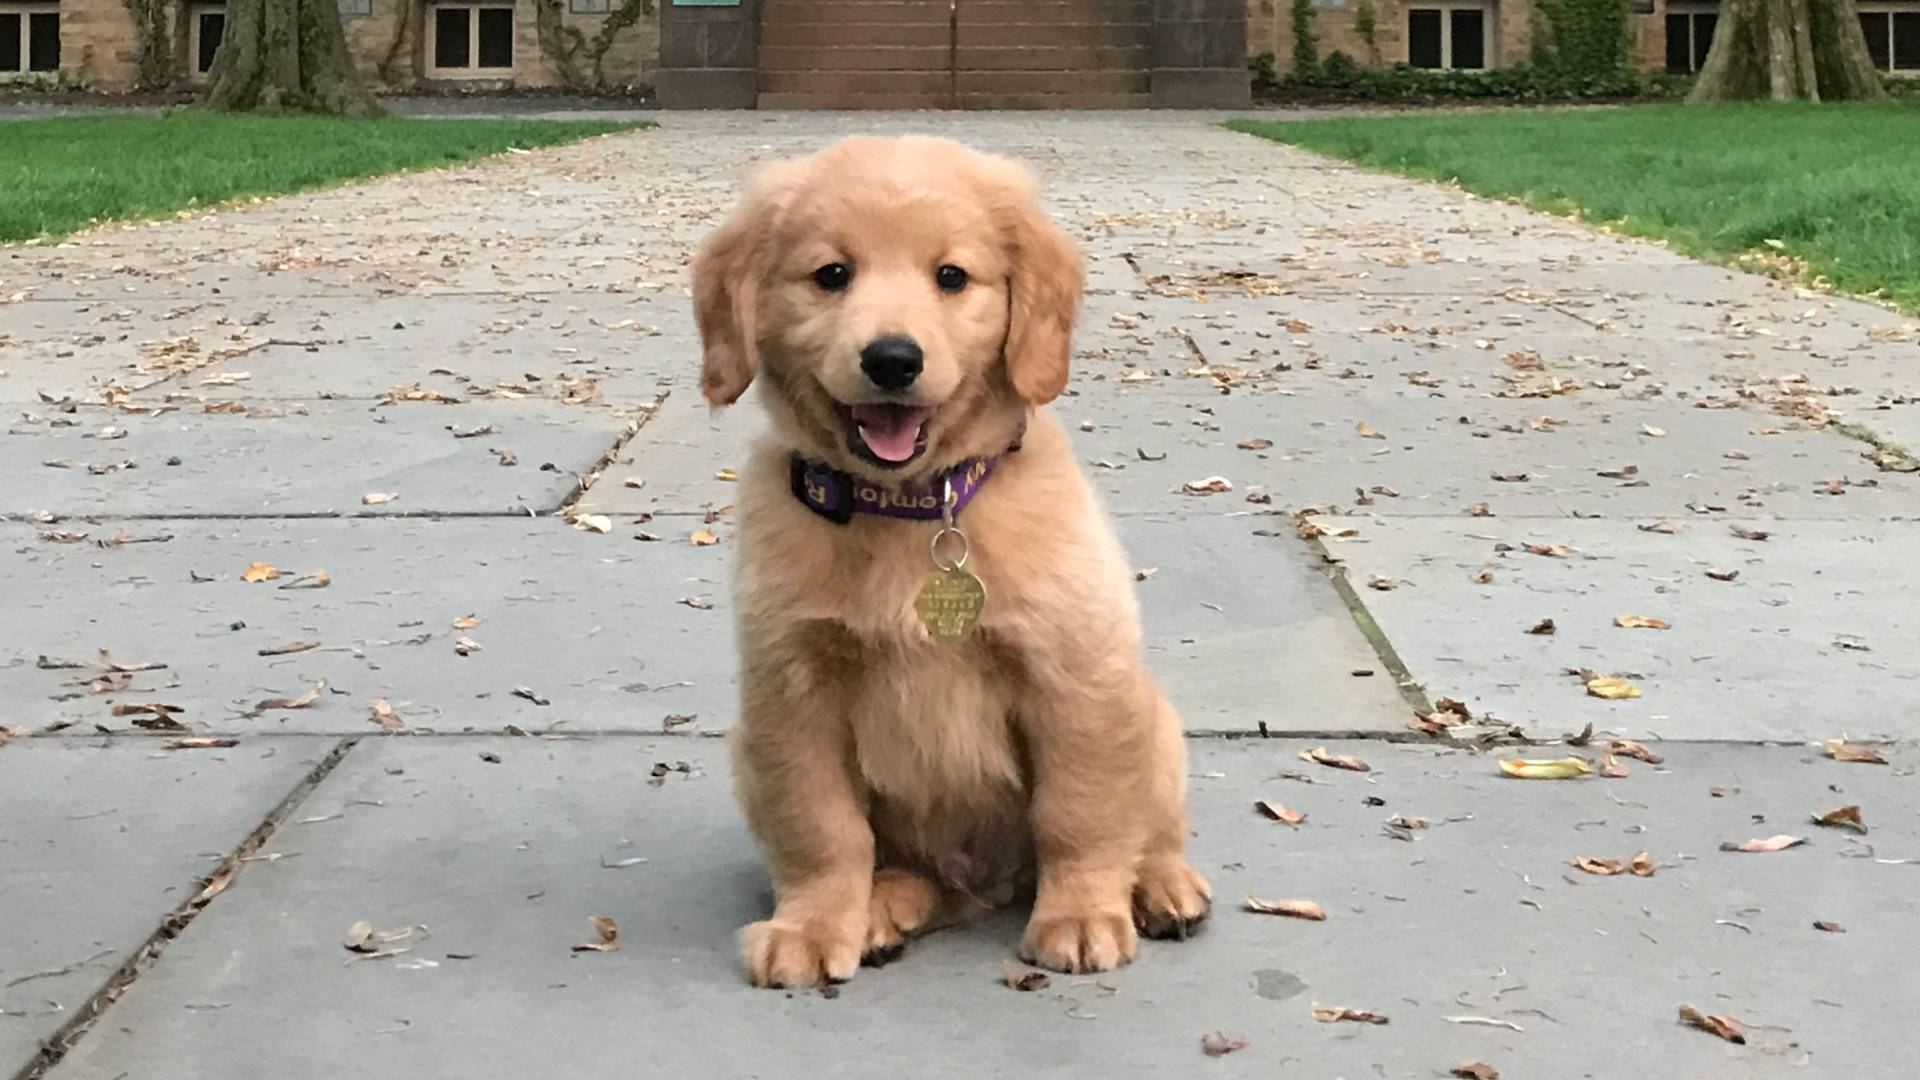

In [21]:
url = "https://www.princeton.edu/sites/default/files/styles/1x_full_2x_half_crop/public/images/2022/02/KOA_Nassau_2697x1517.jpg?itok=Bg2K7j7J"
res = requests.get(url)
image = Image.open(BytesIO(res.content))

inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    outputs = trained_model(**inputs).logits

predicted_label = outputs.argmax(-1).item()
print('predicted label :',labels[predicted_label])

image